# K-means clustering for image segmentation

A few days ago I wrote a post on [pitching matchups for this year's world series](https://dantegates.github.io/2019/10/22/2019-world-series-pitcher-matchups.html).  It began with a model, it ended with a vision. A vision for a scatter plot that was ultimately fulfilled by using K-means for an undeniably tedious but arguably unnecessary task. This post is the story of that story, presented [stream of conciousness](https://en.wikipedia.org/wiki/Stream_of_consciousness)-style.

# The story

It all began with what is now an annual tradition of writing a blog post for the upcoming world series.

I had just got my model to a point where I was happy with it and ready to start thinking about how to present the results. The idea was pitcher vs. batter matchups for each starting pitcher of the first three games of the series. I needed a visualization. A scatter plot pitcher vs. probability of getting an out against each opposing batter seemed like a good place to start. Something like this

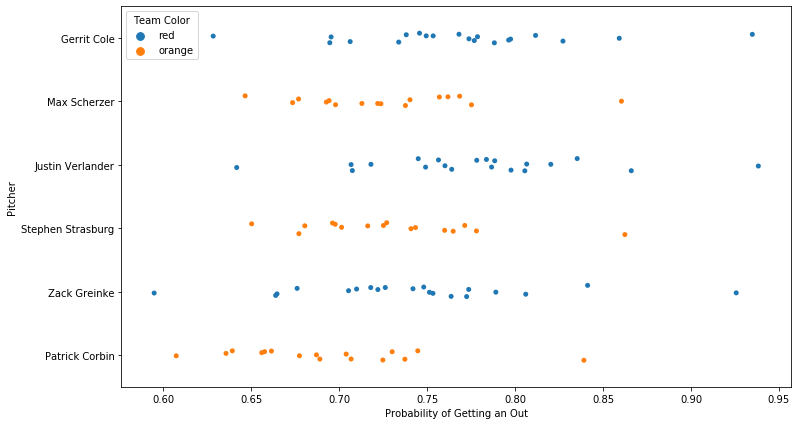

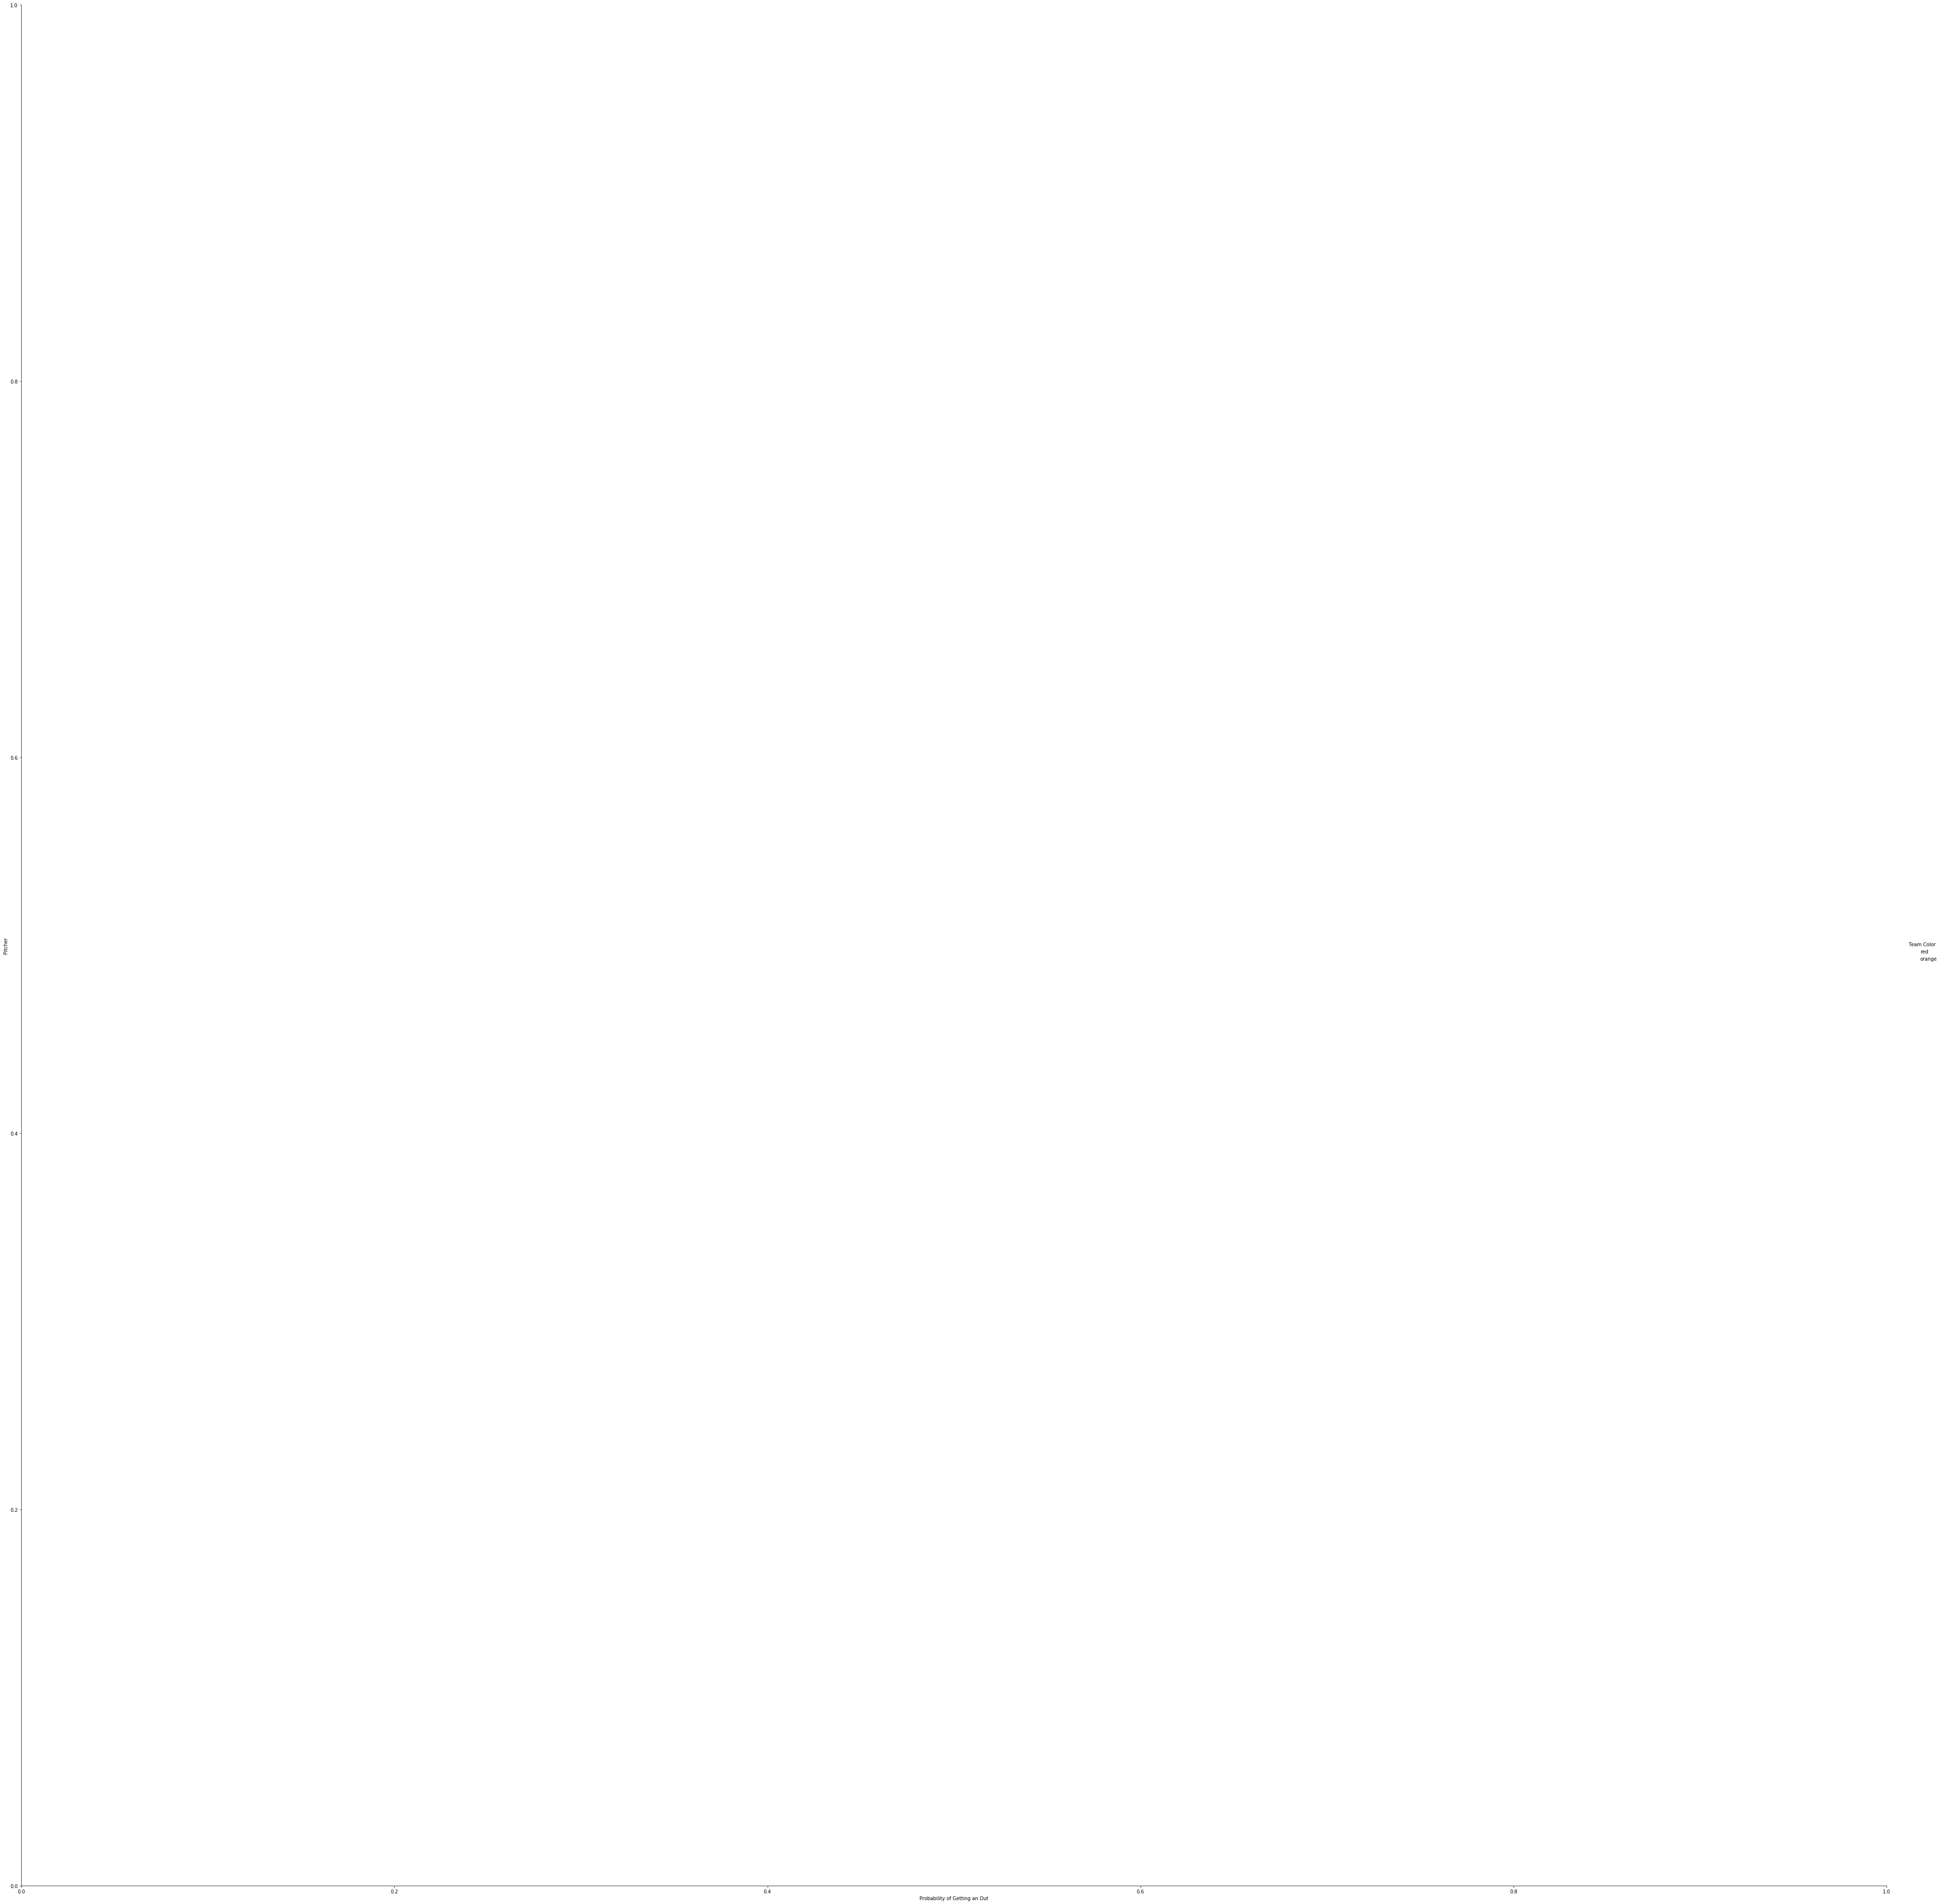

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.read_csv('matchups.csv')
df.sort_values(['Game Number', 'Pitching Team'], inplace=True)
df['Team Color'] = np.where(df['Pitching Team'] == 'HOU', 'red', 'orange')
fig, ax = plt.subplots(figsize=(12, 7))
_ = sns.catplot(y="Pitcher", x="Probability of Getting an Out", data=df, hue='Team Color', ax=ax, height=55)

Hmm... not bad, but what players do those points represent anyway? It would be nice to have that information to make senses of this plot. Alright, time to use [bokeh](https://docs.bokeh.org/en/latest/) to get tooltips. Good thing I've done this exact thing [before](https://dantegates.github.io/2019/06/14/deep-learning-for-tabular-data-2-debunking-the-myth-of-the-black-box.html).

In [11]:
from bokeh.io import show, output_file, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure
from bokeh.sampledata.commits import data
from bokeh.transform import jitter

output_notebook()

output_file("bokeh-plot.html")

pitchers = df.Pitcher.unique()
source = ColumnDataSource(df)

hover = HoverTool(
        tooltips=[
            ("Batter", "@Batter"),
        ]
    )

p = figure(plot_width=800, plot_height=300, y_range=pitchers, tools=[hover])

p.circle(
    x='Probability of Getting an Out',
    y=jitter('Pitcher', width=0.1, range=p.y_range),
    size=10,
    source=source,
    color='Team Color')

show(p)

Loading BokehJS ...

Now I'm getting somewhere. But wait. Something was missing. That's it! I see a vision of this plot using head shots instead of boring old circles. Yea, [that's the ticket](https://www.youtube.com/watch?v=pkYNBwCEeH4).

A few minutes of research later and I found that it was easy enough to programatically fetch the images from the [MLB's website](https://www.mlb.com/) if you knew the player's MLB ID, which was already in the [data set](http://m.mlb.com/glossary/statcast) I was using.

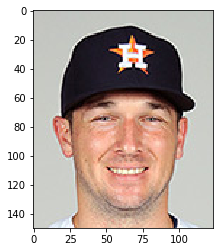

In [13]:
from PIL import Image
import urllib.request

base_url = 'http://gdx.mlb.com/images/gameday/mugshots/mlb/{}@2x.jpg'

def fetch_player_image(player_id):
    url = base_url.format(player_id)
    with urllib.request.urlopen(url) as f:
        image = Image.open(f)
    return image

def show_image(image):
    pixels = image.convert('RGBA').getdata()
    (dim2, dim1), dim3 = image.size, 4
    plt.imshow(np.array(pixels).reshape((dim1, dim2, dim3)))

player_image = fetch_player_image(608324)
show_image(player_image)

Hey, that was easy.

Let's see what's next? I suppose I ought to scan the bokeh docs for how to actually plot these images.

In [14]:
p = figure()

p.image_url(
    url=['http://gdx.mlb.com/images/gameday/mugshots/mlb/608324@2x.jpg'],
    x=[1],
    y=[1],
    w=.01,
    h=3,
    anchor='bottom_left')

show(p)

Okay, one's not too bad. Let's try them all.

In [18]:
df.head()

,Pitcher,Probability of Getting an Out,lower_bound,upper_bound,Batter,Pitching Team,Game Number,LASTNAME,FIRSTNAME,PLAYERID,...,img_url,pitcher_img,label,y,y_offset,y_jitter,headshot,bounds,color,Team Color
0,Gerrit Cole,0.628342,0.609181,0.648406,Andrew Stevenson,HOU,1,Stevenson,Andrew,106961,...,http://gdx.mlb.com/images/gameday/mugshots/mlb...,images/Gerrit Cole.png,Game 1 starter,14,0.507270,14.000000,images/Andrew Stevenson.png,0.039225,orange,red
1,Gerrit Cole,0.694650,0.677189,0.712806,Anthony Rendon,HOU,1,Rendon,Anthony,70755,...,http://gdx.mlb.com/images/gameday/mugshots/mlb...,images/Gerrit Cole.png,Game 1 starter,14,0.929800,14.929800,images/Anthony Rendon.png,0.035617,orange,red
2,Gerrit Cole,0.695392,0.677954,0.713523,Juan Soto,HOU,1,Soto,Juan,107182,...,http://gdx.mlb.com/images/gameday/mugshots/mlb...,images/Gerrit Cole.png,Game 1 starter,14,0.860751,14.000000,images/Juan Soto.png,0.035568,orange,red
3,Gerrit Cole,0.706226,0.689138,0.723974,Howie Kendrick,HOU,1,Kendrick,Howie,45437,...,http://gdx.mlb.com/images/gameday/mugshots/mlb...,images/Gerrit Cole.png,Game 1 starter,14,0.083206,14.083206,images/Howie Kendrick.png,0.034836,orange,red
4,Gerrit Cole,0.733830,0.717720,0.750513,Trea Turner,HOU,1,Turner,Trea,70917,...,http://gdx.mlb.com/images/gameday/mugshots/mlb...,images/Gerrit Cole.png,Game 1 starter,14,0.562086,14.000000,images/Trea Turner.png,0.032793,orange,red


In [20]:
df.columns

Index(['Pitcher', 'Probability of Getting an Out', 'lower_bound',
       'upper_bound', 'Batter', 'Pitching Team', 'Game Number', 'LASTNAME',
       'FIRSTNAME', 'PLAYERID', 'DAVENPORTCODE', 'MLBID', 'RETROSHEETCODE',
       'mlbname', 'img', 'img_url', 'pitcher_img', 'label', 'y', 'y_offset',
       'y_jitter', 'headshot', 'bounds', 'color', 'Team Color'],
      dtype='object')

In [23]:
from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure
from bokeh.transform import jitter, factor_cmap
from bokeh.io import output_notebook
from bokeh.models import HoverTool, LinearColorMapper, CategoricalColorMapper
from bokeh.palettes import Spectral4



output_notebook()
source = ColumnDataSource(df)

y_range = df.Pitcher.unique()

p = figure(
    title='2019 Pitching Matchups',
    x_range=(0.52, .9),
    y_range=pitchers,
    plot_height=600,
    plot_width=1200)

p.image_url(
    url='img',
    x='Probability of Getting an Out',
    y='Pitcher',
    source=source,
    w=.012,
    h=1,
    anchor='center')

output_file('world-series-2019-matchups-no-jitter.html', title='World Series 2019 Pitching Matchups', mode='inline')
show(p)

Loading BokehJS ...

I like where this is going. Although, the backgrounds make this feel a bit amateurish and the overlap is terrible, where is Anthony Rendon?

Let's see, some "jitter" might help.

In [33]:
from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure
from bokeh.transform import jitter, factor_cmap
from bokeh.io import output_notebook
from bokeh.models import HoverTool, LinearColorMapper, CategoricalColorMapper
from bokeh.palettes import Spectral4



output_notebook()
source = ColumnDataSource(df)

y_range = df.Pitcher.unique()

p = figure(
    title='2019 Pitching Matchups',
    x_range=(0.52, .9),
    y_range=pitchers,
    plot_height=600,
    plot_width=1200)

p.image_url(
    url='img',
    x='Probability of Getting an Out',
    y=jitter('Pitcher', width=0.1),
    source=source,
    w=.012,
    h=1,
    anchor='center')

output_file('world-series-2019-matchups-with-jitter.html', title='World Series 2019 Pitching Matchups', mode='inline')
show(p)

Loading BokehJS ...

In [273]:
from PIL import Image
import urllib.request

img_url = 'http://gdx.mlb.com/images/gameday/mugshots/mlb/{}@2x.jpg'

def fetch_player_image(player_id):
    url = img_url.format(player_id)
    with urllib.request.urlopen(url) as f:
        image = Image.open(f)
    return image


def image_to_X(image):
    return np.array(image.getdata('HSV'))





def label_pixels(pixels):
    # one cluster for the background, one for the hat, one for the face
    clf = KMeans(n_clusters=3).fit(pixels)
    return clf.predict(pixels)


def choose_alpha(labels):
    # the first pixel should be the background, set the alpha to 0 for all pixels
    # in this cluster
    return np.where(labels == labels[0], 0, 255)


def set_alpha(image, alpha):
    

In [2]:
X_image = fetch_player_image(608324)

NameError: name 'fetch_player_image' is not defined

In [3]:
from matplotlib.pyplot import imshow

imshow(X_image.data)

NameError: name 'X_image' is not defined

In [1]:
from sklearn.cluster import KMeans

clf = KMeans(n_clusters=3).fit(X_image.hsv)

NameError: name 'X_image' is not defined

In [286]:
label = clf.predict(X_image.hsv)
alpha = np.where(label == label[0], 0, 255)

In [287]:
X_image.set_alpha(alpha)

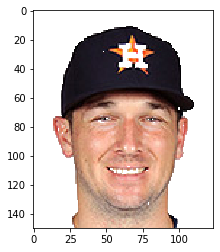

In [288]:
from matplotlib.pyplot import imshow

imshow(X_image.data)